<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 30px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Đồ án thực hành Cuối kỳ - Nhập môn Khoa học Dữ liệu  
</div>

### Giảng viên hướng dẫn:
- Thầy Lê Nhựt Nam
- Cô Nguyễn Thị Thu Hằng
- Thầy Trần Quốc Huy
### Thông tin nhóm: Nhóm 23
| HỌ TÊN                | MSSV      |
|:------------------    |:--------: |
| Lê Trần Minh Khuê     | 21120279  |
| Hoàng Trung Nam       | 21120290  |
| Phan Cao Nguyên       | 21120299  |
| Nguyễn Phương    Thảo | 21120336  |

### Chủ đề: Heart Attack Analysis & Prediction


<div style="text-align: left; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 5px; font-size: 25px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Pha 02 – Xây dựng mô hình dữ liệu và đánh giá 📌
</div>

Thêm các thư viện cần thiết

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime 

import warnings
warnings.filterwarnings('ignore')

# I. Tiền xử lý dữ liệu

In [33]:
smoothed_df = pd.read_csv('Data/smoothed_rate_df.csv')
smoothed_df

,locationid,year,locationabbr,locationdesc,age_group,race/ethnicityage_group,sex,x_long,y_lat,data_value,confidence_limit_low,confidence_limit_high
0,1001,2000,AL,Autauga,Ages 35-64 years,Black,Overall,-86.642959,32.535306,76.9,61.5,99.6
1,1001,2001,AL,Autauga,Ages 35-64 years,Black,Overall,-86.642959,32.535306,83.4,69.0,126.7
2,1001,2002,AL,Autauga,Ages 35-64 years,Black,Overall,-86.642959,32.535306,86.2,66.7,122.1
3,1001,2003,AL,Autauga,Ages 35-64 years,Black,Overall,-86.642959,32.535306,81.6,58.5,117.0
4,1001,2004,AL,Autauga,Ages 35-64 years,Black,Overall,-86.642959,32.535306,84.7,63.7,114.6
...,...,...,...,...,...,...,...,...,...,...,...,...
472677,51053,2017,VA,Dinwiddie,Ages 65+ years,Black,Overall,-77.632205,37.076015,338.8,286.0,402.8
472678,51053,2018,VA,Dinwiddie,Ages 65+ years,Black,Overall,-77.632205,37.076015,321.9,261.5,415.1
472679,51053,2019,VA,Dinwiddie,Ages 65+ years,Black,Overall,-77.632205,37.076015,334.5,272.5,459.4
472680,51053,2000,VA,Dinwiddie,Ages 65+ years,Overall,Female,-77.632205,37.076015,433.1,342.3,525.8


## I.1 Loại bỏ các cột không cần thiết

In [34]:
smoothed_df.drop(['confidence_limit_low', 'confidence_limit_high','x_long','y_lat'], axis=1, inplace=True)
smoothed_df

,locationid,year,locationabbr,locationdesc,age_group,race/ethnicityage_group,sex,data_value
0,1001,2000,AL,Autauga,Ages 35-64 years,Black,Overall,76.9
1,1001,2001,AL,Autauga,Ages 35-64 years,Black,Overall,83.4
2,1001,2002,AL,Autauga,Ages 35-64 years,Black,Overall,86.2
3,1001,2003,AL,Autauga,Ages 35-64 years,Black,Overall,81.6
4,1001,2004,AL,Autauga,Ages 35-64 years,Black,Overall,84.7
...,...,...,...,...,...,...,...,...
472677,51053,2017,VA,Dinwiddie,Ages 65+ years,Black,Overall,338.8
472678,51053,2018,VA,Dinwiddie,Ages 65+ years,Black,Overall,321.9
472679,51053,2019,VA,Dinwiddie,Ages 65+ years,Black,Overall,334.5
472680,51053,2000,VA,Dinwiddie,Ages 65+ years,Overall,Female,433.1


Do `locationid` và `locationdesc` là mã và tên của các quận (county), cùng có thể dùng để phân biệt một quận. Việc tồn tại 2 thuộc tính có ý nghĩa tương tự nhau có vẻ không cần thiết. Ngoài ra, số lượng `locationid` là rất lớn và tuy nhiên giá trị không đóng góp nhiều vào việc dự đoán, nên ta sẽ loại bỏ cả 2 cột `locationid` và `locationdesc`. 

Nhưng giá trị data_value tính theo county, nên ta thực hiện xử lý gom nhóm các dòng cùng locationabbr (bang) và tính data_value cho bang = mean của các dòng thành phần.

In [35]:
counties = {'locationid': smoothed_df['locationid'], 'locationdesc':smoothed_df['locationdesc']}
counties_df = pd.DataFrame(counties)
smoothed_df.drop(['locationdesc'], axis=1, inplace=True)

state_df = smoothed_df.groupby(['locationabbr','age_group','race/ethnicityage_group','sex'])['data_value'].mean().reset_index()

In [36]:
state_df

,locationabbr,age_group,race/ethnicityage_group,sex,data_value
0,AK,Ages 35-64 years,Overall,Male,37.396250
1,AK,Ages 35-64 years,Overall,Overall,31.903889
2,AK,Ages 35-64 years,White,Overall,23.356000
3,AK,Ages 65+ years,American Indian and Alaska Native,Overall,410.375000
4,AK,Ages 65+ years,Overall,Female,270.030833
...,...,...,...,...,...
653,VT,Ages 35-64 years,White,Overall,33.143077
654,VT,Ages 65+ years,Overall,Female,497.391538
655,VT,Ages 65+ years,Overall,Male,596.065417
656,VT,Ages 65+ years,Overall,Overall,545.325000


## I.2. Xác định biến Categorical/ Numeric

In [37]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   locationabbr             658 non-null    object 
 1   age_group                658 non-null    object 
 2   race/ethnicityage_group  658 non-null    object 
 3   sex                      658 non-null    object 
 4   data_value               658 non-null    float64
dtypes: float64(1), object(4)
memory usage: 25.8+ KB


In [38]:
# Biến Categorical
cat_vars = ['locationabbr','age_group','race/ethnicityage_group','sex']
# Biến numerical
num_vars = ['data_value']

Với biến numerical, nhóm dùng distplot để vẽ biểu đồ phân bố của các đặc trưng: 

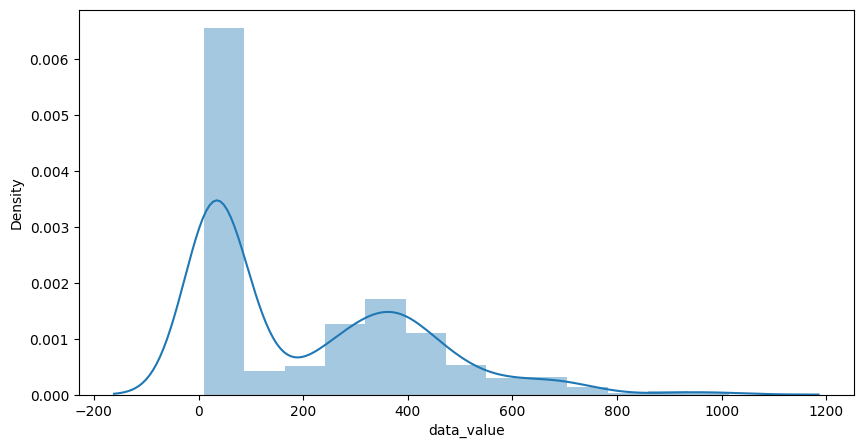

In [39]:
plt.figure(figsize = (10, 5))
sns.distplot(state_df[num_vars[0]])
plt.show()

Ta thấy ở thuộc tính `data_value`, dữ liệu tập trung ở mức dưới 1000. Nên ta sẽ loại bỏ đi các dòng có giá trị data_value >1000.

In [40]:
# Xem xét thống kê mô tả đối với các cột numeric (trước khi xử lý)
state_df[num_vars].describe()

,data_value
count,658.000000
mean,207.643015
std,209.463608
min,10.033333
25%,28.317875
50%,84.705000
75%,368.706334
max,1013.725000


## I.3. Loại bỏ outliers

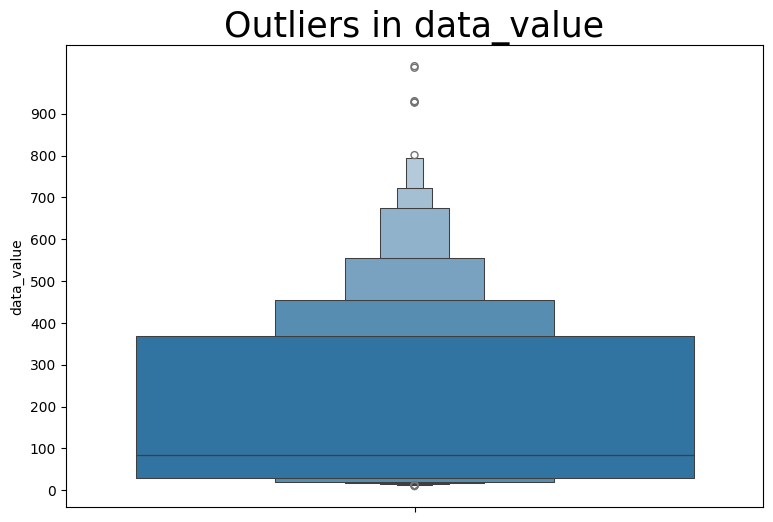

In [41]:
for col in num_vars:
    plt.figure(figsize=(9,6))
    sns.boxenplot(y=col,data=state_df)
    plt.title('Outliers in {}'.format(col),fontsize=25,fontweight=5)
    plt.yticks(range(0,1000,100))
    plt.show()

In [42]:
# Xử lý loại bỏ các data_value >1000
state_df.drop(state_df[state_df['data_value']>1000].index,inplace=True)

In [43]:
# # Xem xét thống kê mô tả đối với các cột numeric (sau khi xử lý)
state_df[num_vars].describe()

,data_value
count,656.000000
mean,205.191332
std,205.008306
min,10.033333
25%,28.180090
50%,84.094600
75%,365.797346
max,930.099000


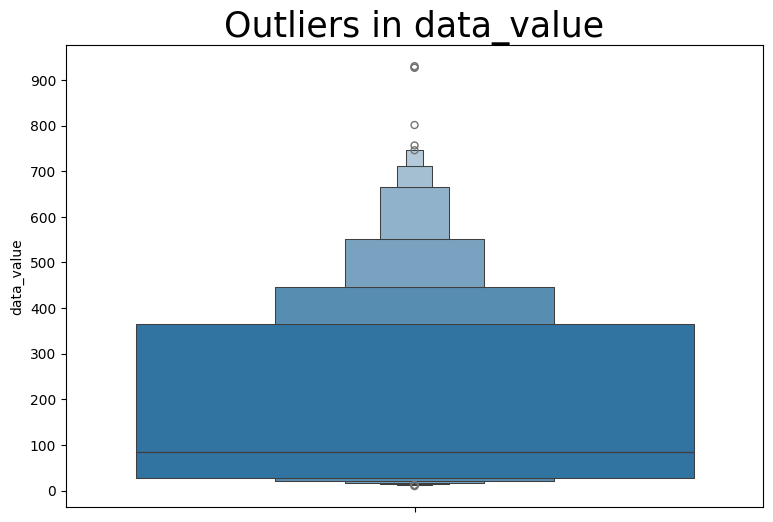

In [44]:
for col in num_vars:
    plt.figure(figsize=(9,6))
    sns.boxenplot(y=col,data=state_df)
    plt.title('Outliers in {}'.format(col),fontsize=25,fontweight=5)
    plt.yticks(range(0,1000,100))
    plt.show()

# II. Chọn các đặc trưng để xây dựng mô hình
## II.1. Chuyển các cột dạng Categorical sang Numerical

Ta sẽ dùng hàm get_dummies để chuyển cột dạng Categorical sang Numerical theo phương pháp one-hot encoding

Lý do dùng: Vì các cột dạng categorical không có dạng order (có thứ tự) nên dùng one-hot encoding sẽ đem lại hiệu quả cao hơn so với phương pháp encoding khác.

In [45]:
state_df

,locationabbr,age_group,race/ethnicityage_group,sex,data_value
0,AK,Ages 35-64 years,Overall,Male,37.396250
1,AK,Ages 35-64 years,Overall,Overall,31.903889
2,AK,Ages 35-64 years,White,Overall,23.356000
3,AK,Ages 65+ years,American Indian and Alaska Native,Overall,410.375000
4,AK,Ages 65+ years,Overall,Female,270.030833
...,...,...,...,...,...
653,VT,Ages 35-64 years,White,Overall,33.143077
654,VT,Ages 65+ years,Overall,Female,497.391538
655,VT,Ages 65+ years,Overall,Male,596.065417
656,VT,Ages 65+ years,Overall,Overall,545.325000


In [46]:
df_new =state_df.drop(columns=['data_value'])
df_new = pd.get_dummies(df_new)
df_new['data_value'] =state_df['data_value']
df_new

,locationabbr_AK,locationabbr_AL,locationabbr_AR,locationabbr_AZ,locationabbr_CA,locationabbr_CO,locationabbr_CT,locationabbr_DC,locationabbr_DE,locationabbr_FL,...,race/ethnicityage_group_American Indian and Alaska Native,race/ethnicityage_group_Asian and Pacific Islander,race/ethnicityage_group_Black,race/ethnicityage_group_Hispanic,race/ethnicityage_group_Overall,race/ethnicityage_group_White,sex_Female,sex_Male,sex_Overall,data_value
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,37.396250
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,31.903889
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,23.356000
3,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,410.375000
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,270.030833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,33.143077
654,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,497.391538
655,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,596.065417
656,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,545.325000


## II.2 Bỏ đi những cột có tương quan thấp với data_value

Xem xét loại bỏ các cột có độ tương quan thấp với data_value (<0,01).

In [47]:
# Tính toán ma trận tương quan 
corr_matrix = df_new.corr()

In [48]:
# Vẽ heatmap minh hoạ
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
#plt.title('Heatmap of Correlation Matrix')
#plt.show()


In [49]:
# Lọc các cột có độ tương quan ít hơn ngưỡng (0.01) với cột 'data_value'
corr_value = corr_matrix['data_value']
drop_columns = corr_value[abs(corr_value) < 0.01].index
df_new.drop(columns=drop_columns, inplace=True)


Như vậy, ta sẽ sử dụng những đặc trưng như sau để xây dựng mô hình

In [50]:
df_new.drop(columns='data_value').columns

Index(['locationabbr_AL', 'locationabbr_CA', 'locationabbr_CO',
       'locationabbr_CT', 'locationabbr_DC', 'locationabbr_HI',
       'locationabbr_IA', 'locationabbr_ID', 'locationabbr_KS',
       'locationabbr_MA', 'locationabbr_MD', 'locationabbr_ME',
       'locationabbr_MI', 'locationabbr_MN', 'locationabbr_MO',
       'locationabbr_MS', 'locationabbr_MT', 'locationabbr_NC',
       'locationabbr_NE', 'locationabbr_NH', 'locationabbr_NJ',
       'locationabbr_NV', 'locationabbr_OH', 'locationabbr_OK',
       'locationabbr_PA', 'locationabbr_SC', 'locationabbr_SD',
       'locationabbr_TN', 'locationabbr_TX', 'locationabbr_UT',
       'locationabbr_VA', 'locationabbr_VT', 'age_group_Ages 35-64 years',
       'age_group_Ages 65+ years',
       'race/ethnicityage_group_American Indian and Alaska Native',
       'race/ethnicityage_group_Asian and Pacific Islander',
       'race/ethnicityage_group_Black', 'race/ethnicityage_group_Hispanic',
       'race/ethnicityage_group_Overall', 'ra

# III. Xây dựng mô hình

In [51]:
#from sklearn.linear_model import LogisticRegression
#import statsmodels.api as sm


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, accuracy_score, classification_report

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import time

#sns.set(style="whitegrid")


In [52]:
X = df_new.drop(columns=['data_value'])
y = df_new['data_value']

## III.1 Chuẩn hoá dữ liệu

 Ta dùng phương pháp MinMaxScaler để scale dữ liệu về khoảng [0,1]

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(X,y)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

## III.2. Chia các tập train, test

Chia tập train/test với tỷ lệ là 75:25

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

## III.3 Chọn các mô hình tốt nhất

Ta sẽ dùng phương pháp K Fold Cross Validation để đánh giá và chọn ra các mô hình tốt nhất. Sau khi chạy thử với nhiều k thì tụi em chọn k=7 vì nó có hiệu quả tốt nhất.

Lý do dùng: Bởi vì tập dữ liệu khá nhỏ (656 rows), nếu chia ra các tập train/val/test thì không thật sự đo được độ hiệu quả của mô hình (vì mỗi tập quá ít dữ liệu). Dùng K Fold Cross Validation thì mọi phần trong tập train sẽ được dùng cho cả việc train và test, nhờ đó ta sẽ đánh giá chính xác hơn độ hiệu quả của mô hình.

In [55]:
from sklearn.model_selection import cross_val_score

Ta dùng điểm cross-validation đánh giá hiệu suất của mô hình trên dữ liệu mới mà nó chưa được huấn luyện.

1. **Giá trị trung bình và độ lệch chuẩn:**
   - **Giá trị trung bình (Mean Score):** Cho biết điểm trung bình của mô hình trên các fold. Nếu giá trị này cao, mô hình càng hiệu quả.
   - **Độ lệch chuẩn (Standard Deviation):** Mô tả mức độ biến động của các điểm trên các fold. Nếu độ lệch chuẩn lớn, có thể có sự bất ổn định trong hiệu suất của mô hình trên các tập dữ liệu khác nhau.
   
2. **Đánh giá sự ổn định của mô hình:**
   - Nếu độ lệch chuẩn lớn, có thể đề xuất rằng mô hình có thể không ổn định trên các tập dữ liệu khác nhau. Điều này có thể là dấu hiệu của overfitting, nghĩa là mô hình quá mức điều chỉnh cho dữ liệu huấn luyện cụ thể và không tổng quát hóa tốt trên dữ liệu mới.

Do đó, nhóm em tiến hành chạy thử và ghi nhận `mean score`, `std` của các mô hình, từ đó chọn ra 3 mô hình tốt nhất.

Ta sẽ chọn các thuật toán để kiểm tra là LinearRegression, Support Vector Regression, Decision Tree Regression, Ridge, Lasso, KNeighborsRegressor, RandomForestRegressor

In [56]:
# Khởi tạo các mô hình
models = {
    'Linear Regression': LinearRegression(),
    #'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'KNeighbors Regression': KNeighborsRegressor(),
    'Random Forest Regression': RandomForestRegressor()
}

# Tạo DataFrame để lưu kết quả
model_results_list =[]

# Chạy cross-validation cho từng mô hình và ghi nhận kết quả
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=7)
    mean_score = scores.mean()
    std_dev = scores.std()
    
    # Thêm kết quả vào list
    model_results_list.append({
        'Model': model_name,
        'Mean Score': mean_score,
        'Standard Deviation': std_dev
    })

# Tạo DataFrame từ list kết quả
model_results_df = pd.DataFrame(model_results_list)

model_results_df.sort_values(by= 'Mean Score', ascending= False, inplace=True)

In [60]:
model_results_df

,Model,Mean Score,Standard Deviation
6,Random Forest Regression,0.924240,0.029587
2,Decision Tree Regression,0.909493,0.054056
5,KNeighbors Regression,0.876379,0.038819
3,Ridge Regression,0.865754,0.026312
0,Linear Regression,0.862078,0.027009
4,Lasso Regression,0.854966,0.028921
1,Support Vector Regression,0.057037,0.096191


**Biểu diễn kết quả nhận được dưới dạng đồ thị**

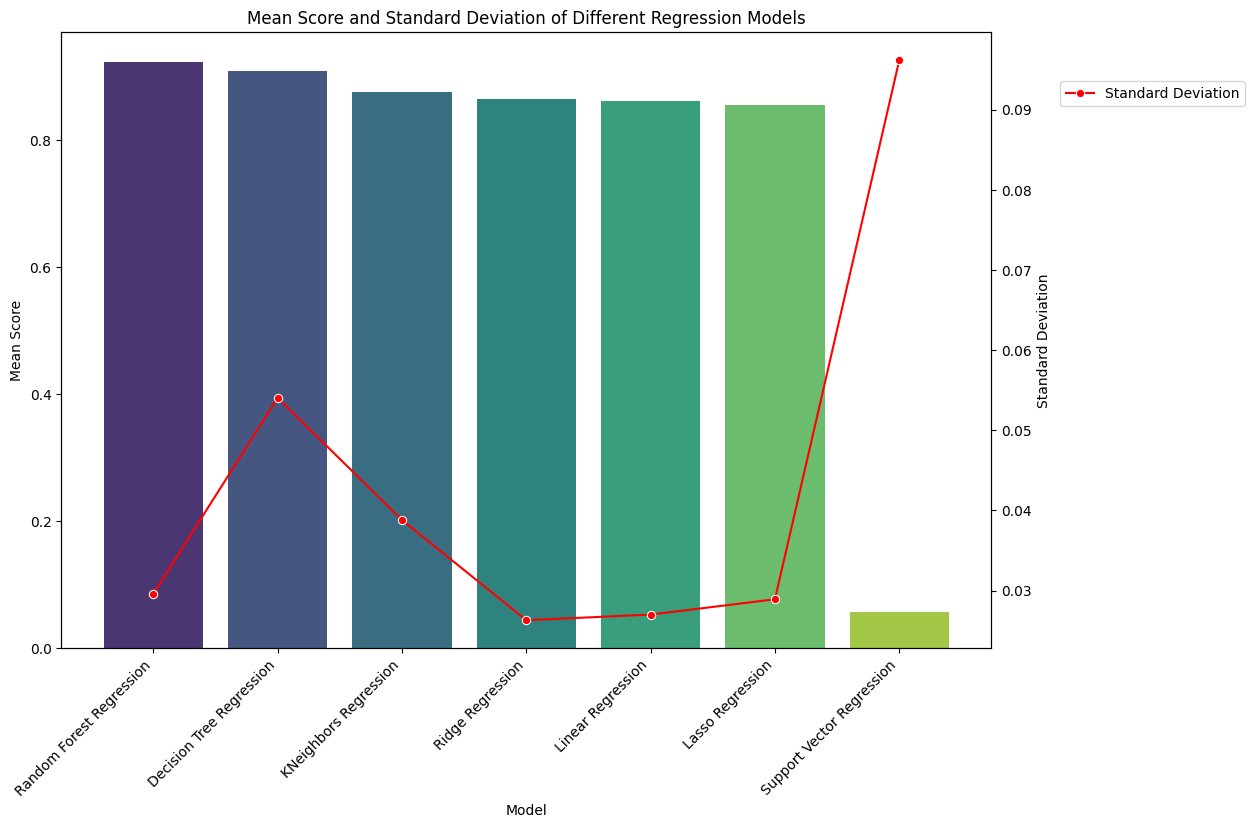

In [57]:
# Vẽ biểu đồ cột và đường trên cùng 1 xbar
fig, ax = plt.subplots(figsize=(12, 8))

# Biểu đồ Mean Score (bar chart)
sns.barplot(x='Model', y='Mean Score', data=model_results_df, palette='viridis', ax=ax, label='Mean Score')
ax.set_title('Mean Score and Standard Deviation of Different Regression Models')
ax.set_ylabel('Mean Score')

# Hiển thị tên model nghiên 45 độ
plt.xticks(rotation=45, ha='right')

# Vẽ đường cho Standard Deviation
ax2 = ax.twinx()
sns.lineplot(x='Model', y='Standard Deviation', data=model_results_df, color='red', marker='o', label='Standard Deviation', ax=ax2)
ax2.set_ylabel('Standard Deviation')

# Tắt grid
ax.grid(False)
ax2.grid(False)

# Hiển thị chú thích vị trí bên ngoài biểu đồ
ax2.legend(loc='center right', bbox_to_anchor=(1.28,0.9))

plt.show()


Dễ dàng nhận thấy 3 mô hình cho kết quả `mean score` tốt nhất là:
1. **Random Forest Regression**: Điểm trung bình cao (0.924) và độ lệch chuẩn thấp (0.03). Khá phù hợp với dữ liệu khi độ bất ổn định giữa các fold thấp.

2. **Decision Tree Regression**: Điểm trung bình tốt (0.91) nhưng độ lệch chuẩn ~ 0.05 (khá cao so với 2 mô hình còn lại)

3. **KNeighbors Regression**: Điểm trung bình tốt (0.876) và độ lệch chuẩn thấp ~ 0.039

## III.4 Tiến hành huấn luyện mô hình
Cho các mô hình này lần lượt chạy trên tập train và test để đo độ hiệu quả của chúng.

Ta sẽ tính các giá trị đo độ lỗi như sau:

- MAE: lỗi trị tuyệt đối trung bình
- MSE: lỗi bình phương trung bình
- RMSE: sai số bình phương trung bình căn
- R2_score: mức độ phù hợp của mô hình với tập dữ liệu

===